In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt


### 1. Open file

In [2]:
# Leitura dos dados IBGE
path="/home/akel/PycharmProjects/Data_ambiental/data/process/"
df1 = pd.read_csv(path+'tabela_total_final.csv')

# Leitura dos dados dissertação
path="/home/akel/PycharmProjects/Data_ambiental/data/raw/"
df2 = pd.read_csv(path+'depositos_iregulares.Bairros.csv')


#Verificar consistência de Bairro entre fontes
a=df1['Bairro'].unique().tolist()
A=df2['Bairro'].unique().tolist()
# Novo dataframe df
df = df1.merge(df2, on="Bairro", how="left")
#Nova feature CRA=Concentração de Renda por Área 
df['CRA']=df['Mor/Hab']*df['ren_avg']/df['area_km2']

df.head(5)

,Bairro,area_km2,Hab,Mor,Mor/Hab,N_ren,ren_avg,ren_mdn,T.A.,IDH-R,IDH-L,IDH-E,IDH,Quantidade de Depósitos Irregulares,CRA
0,Batista Campos,1.425387,5795,19062,3.29,11763.0,3742.05,2000.0,99.20,0.869,0.901,0.829,0.866,NaN,8637.191580
1,Canudos,0.798429,3619,13789,3.81,7863.0,1275.72,700.0,98.07,0.751,0.873,0.752,0.790,NaN,6087.571117
2,Cidade Velha,1.474443,3086,12119,3.93,6976.0,1931.71,1000.0,98.64,0.828,0.891,0.802,0.840,3.0,5148.804637
3,Condor,1.822802,10414,42699,4.10,20917.0,845.55,510.0,96.38,0.616,0.769,0.549,0.644,NaN,1901.881942
4,Cremação,1.474000,8324,31257,3.76,17096.0,1769.97,800.0,98.18,0.690,0.825,0.668,0.724,NaN,4514.983583


### 2. Separação de variaveis

In [3]:
# Variáveis (Features) que você está usando
features = ["area_km2", "Hab", "Mor", "Mor/Hab", "N_ren", "ren_avg", "ren_mdn", "T.A.", "IDH",'CRA']
target = "Quantidade de Depósitos Irregulares"

# Cria o conjunto de dados válidos para treino (21 amostras)
df_validas = df.dropna(subset=[target]).copy() #21 amostras
df_missing = df[df[target].isna()].copy()     #~50 amostras sem dados

#df_missing=df.copy()
#df_missing[target]=np.nan

print(f"Amostras para TREINO (válidas): {len(df_validas)}")
print(f"Amostras para PREVISÃO (ausentes): {len(df_missing)}")

Amostras para TREINO (válidas): 21
Amostras para PREVISÃO (ausentes): 50


### 3. Treinamento 


=== Métricas de Treinamento do Ridge Regression (21 Amostras) ===
R² (Coeficiente de Determinação): 0.8544
MAE (Erro Absoluto Médio): 0.8570
RMSE (Raiz do Erro Quadrático Médio): 1.2215


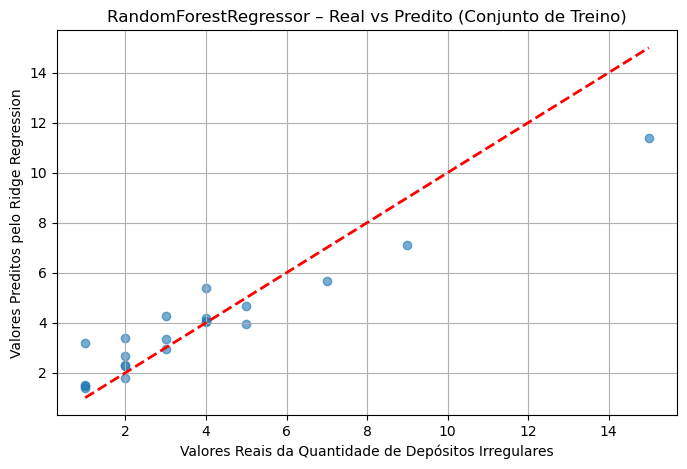


=== Importância das Variáveis (Random Forest) ===
    Feature  Importancia
9       CRA     0.271505
0  area_km2     0.233943
3   Mor/Hab     0.125749
7      T.A.     0.101651
8       IDH     0.083627
2       Mor     0.052999
1       Hab     0.046757
4     N_ren     0.041356
5   ren_avg     0.027122
6   ren_mdn     0.015291


In [4]:
X_train = df_validas[features]
y_train = df_validas[target]
X_predict = df_missing[features] #

# Inicializa o modelo Ridge (simples e regularizado, ideal para 21 amostras)
model_RF = RandomForestRegressor(n_estimators=500, random_state=42)

# Treina o modelo APENAS nas 21 amostras válidas
model_RF.fit(X_train, y_train)

y_pred_train = model_RF.predict(X_train)

# ----------------------------------------------------------------------
## 📈 Métricas de Treinamento
# ----------------------------------------------------------------------
r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("\n=== Métricas de Treinamento do Ridge Regression (21 Amostras) ===")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f"MAE (Erro Absoluto Médio): {mae:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")

# ----------------------------------------------------------------------
## 📉 Gráfico de Dispersão (Real vs. Predito)
# ----------------------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_pred_train, alpha=0.6) 
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2) 
plt.xlabel("Valores Reais da Quantidade de Depósitos Irregulares")
plt.ylabel("Valores Preditos pelo Ridge Regression")
plt.title("RandomForestRegressor – Real vs Predito (Conjunto de Treino)")
plt.grid(True)
plt.show()


# 3. Coeficientes do Modelo
# ⚠️ CORREÇÃO: Usamos .feature_importances_ para Random Forest
importances = model_RF.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

print("\n=== Importância das Variáveis (Random Forest) ===")
print(feature_importance)

### 4. Estimativas de Descartes

In [5]:
predictions= model_RF.predict(X_predict)

predictions_rounded = np.round(predictions)
predictions_series = pd.Series(predictions_rounded, index=df_missing.index)

df['Depósitos Irregulares est.']=predictions_series

df['Depósitos Irregulares est.'] = (
    df['Depósitos Irregulares est.']
    .fillna(df['Quantidade de Depósitos Irregulares'])
    .astype(int)
)

# --- 5. RESULTADO FINAL ---

print("\n--- Estimação e Imputação Final Concluída (Ridge Regression) ---")
print(f"Total de valores imputados: {len(predictions_rounded)}")
print(f"Média das estimativas imputadas: {np.mean(predictions_rounded):.2f}")
print("-" * 60)
print("Seu DataFrame 'df' agora contém a coluna 'Quantidade de Depósitos Irregulares' completa!")

# Exibe as estatísticas finais da coluna completa
print("\nEstatísticas da Coluna Alvo (21 coletados + ~50 estimados):")
print(df[target].describe())

df.head(60)


--- Estimação e Imputação Final Concluída (Ridge Regression) ---
Total de valores imputados: 50
Média das estimativas imputadas: 4.60
------------------------------------------------------------
Seu DataFrame 'df' agora contém a coluna 'Quantidade de Depósitos Irregulares' completa!

Estatísticas da Coluna Alvo (21 coletados + ~50 estimados):
count    21.000000
mean      3.809524
std       3.280534
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      15.000000
Name: Quantidade de Depósitos Irregulares, dtype: float64


,Bairro,area_km2,Hab,Mor,Mor/Hab,N_ren,ren_avg,ren_mdn,T.A.,IDH-R,IDH-L,IDH-E,IDH,Quantidade de Depósitos Irregulares,CRA,Depósitos Irregulares est.
0,Batista Campos,1.425387,5795,19062,3.29,11763.0,3742.05,2000.0,99.20,0.869,0.901,0.829,0.866,NaN,8637.191580,2
1,Canudos,0.798429,3619,13789,3.81,7863.0,1275.72,700.0,98.07,0.751,0.873,0.752,0.790,NaN,6087.571117,3
2,Cidade Velha,1.474443,3086,12119,3.93,6976.0,1931.71,1000.0,98.64,0.828,0.891,0.802,0.840,3.0,5148.804637,3
3,Condor,1.822802,10414,42699,4.10,20917.0,845.55,510.0,96.38,0.616,0.769,0.549,0.644,NaN,1901.881942,5
4,Cremação,1.474000,8324,31257,3.76,17096.0,1769.97,800.0,98.18,0.690,0.825,0.668,0.724,NaN,4514.983583,4
5,Guamá,4.310685,23402,94432,4.04,44917.0,940.73,510.0,95.91,0.709,0.830,0.699,0.746,4.0,881.657789,4
6,Jurunas,2.557641,15886,64478,4.06,32828.0,1065.28,510.0,95.99,0.778,0.872,0.762,0.802,9.0,1691.025975,9
7,Marambaia,5.052314,17563,66697,3.80,35312.0,1357.51,710.0,97.43,0.792,0.805,0.772,0.813,5.0,1021.024833,5
8,Marco,4.903819,18162,65819,3.62,36975.0,2096.32,1000.0,98.38,0.833,0.888,0.803,0.841,3.0,1547.503739,3
9,Fátima,0.619498,3008,12385,4.12,6379.0,1124.57,600.0,98.19,0.720,0.856,0.721,0.763,NaN,7478.999121,4


In [6]:
# salvar os novos dados
def salvar_csv(df, caminho):
    if os.path.exists(caminho):
        print(f"⚠️ Arquivo já existe e NÃO será sobrescrito: {caminho}")
    else:
        df.to_csv(caminho, index=False)
        print(f"✅ Arquivo salvo: {caminho}")

path = '/home/akel/PycharmProjects/Data_ambiental/data/process/'
salvar_csv(df, path + 'Descartes_RF.csv')


⚠️ Arquivo já existe e NÃO será sobrescrito: /home/akel/PycharmProjects/Data_ambiental/data/process/Descartes_RF.csv
